In [1]:
import os
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.set_cmap('jet')
%matplotlib inline

from collections import Counter
from glob import iglob
from ipywidgets import FloatSlider, interact
import medpy, medpy.io  # need to pip install itk as well
import numpy as np
import pandas as pd
import random
import skimage
from skimage.io import imread, imsave


In [2]:
random.seed(1234)
np.random.seed(1234)


In [3]:
basepath = '/data/lisa/data/BRATS2013'

path = 'cyclegan/datasets/brats2013-var/'
path_paired = 'cyclegan/datasets/brats2013-paired/'
holdoutpath = 'cyclegan/datasets/brats2013-holdout/'


In [4]:
#clear existing data
!rm -rf $path
!rm -rf $path_paired
!rm -rf $holdoutpath


In [5]:
# Get the data

def get_data(glob_pattern, is_labels=False):
    data = {}
    for filename in iglob(glob_pattern):
        print '.',
        path = os.path.normpath(filename).split(os.sep)
        number = list(reversed(path))[2]
        level = list(reversed(path))[3]
        name = level + number
        
        image_data, image_header = medpy.io.load(filename)
        image_data = image_data.T

        if (is_labels):
            image_data = np.round(image_data)  # clean up labels

        image_data = image_data[:, :, 128:]  # crop right side
        data[name] = image_data
    return data

flair = get_data(basepath + '/Synthetic_Data/*/*/*/*Flair.*N4ITK.mha')
t1 = get_data(basepath + '/Synthetic_Data/*/*/*/*T1.*N4ITK.mha')
t1c = get_data(basepath + '/Synthetic_Data/*/*/*/*T1c.*N4ITK.mha')
t2 = get_data(basepath + '/Synthetic_Data/*/*/*/*T2.*N4ITK.mha')
labels = get_data(basepath + '/Synthetic_Data/*/*/*/*5more*N4ITK.mha', is_labels=True)

print 'Done'

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Done


In [6]:

def normalize_data(data):
    # Scale between 0 and 1 so we can export it as an image
    max_val = np.asarray(data.values()).max()
    for k, v in data.iteritems():
        data[k] = v / max_val * 100.  # * 100 to have a sufficient resolution to save
        data[k] = data[k].astype(np.uint8)
    new_max_val = np.asarray(data.values()).max()
    print 'normalize', max_val, '->', new_max_val


In [7]:
# Normalize inplace
normalize_data(flair)
normalize_data(t1)
normalize_data(t1c)
normalize_data(t2)


normalize 2763.168 -> 100
normalize 11040.32 -> 100
normalize 4677.0083 -> 100
normalize 4317.0947 -> 100


In [8]:
# Shape should be (# slide, y, x)
print labels['LG0001'].shape


(181, 256, 128)


In [9]:

def get_labels(rightside):
    met = {}
    met['brain'] = (
        1. * (rightside != 0).sum() / (rightside == 0).sum())
    met['tumor'] = (
        1. * (rightside > 2).sum() / ((rightside != 0).sum() + 1e-10))
    met['has_enough_brain'] = met['brain'] > 0.30
    met['has_tumor'] = met['tumor'] > 0.01
    return met


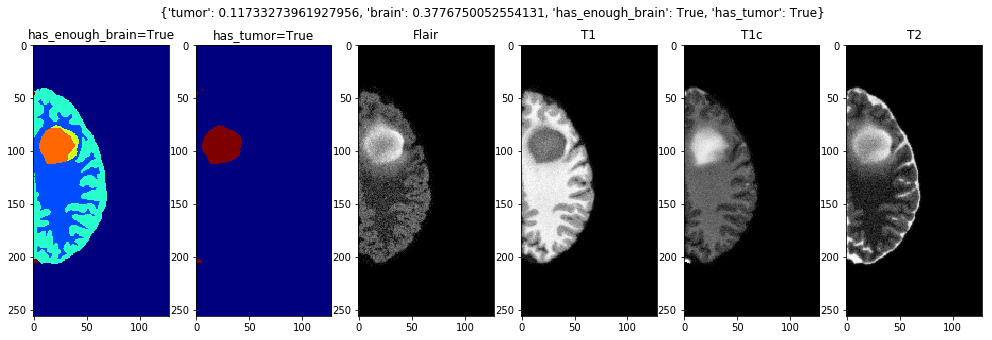

In [10]:
# Visualize a tumor sample
sample = 'HG0001'
slide = 104

label = labels[sample][slide]
fla = flair[sample][slide]
it1 = t1[sample][slide]
it1c = t1c[sample][slide]
it2 = t2[sample][slide]

met = get_labels(label)

plt.rcParams['figure.figsize'] = (17, 9)
fig, axarr = plt.subplots(1, 6)
axarr[0].imshow(label)
axarr[0].set_title('has_enough_brain=' + str(met['has_enough_brain']))
axarr[1].imshow(label > 2)
axarr[1].set_title('has_tumor=' + str(met['has_tumor']))
axarr[2].imshow(1.0 - fla, cmap='Greys')
axarr[2].set_title('Flair')
axarr[3].imshow(1.0 - it1, cmap='Greys')
axarr[3].set_title('T1')
axarr[4].imshow(1.0 - it1c, cmap='Greys')
axarr[4].set_title('T1c')
axarr[5].imshow(1.0 - it2, cmap='Greys')
axarr[5].set_title('T2')

fig.suptitle(met, y=0.77)
plt.show()


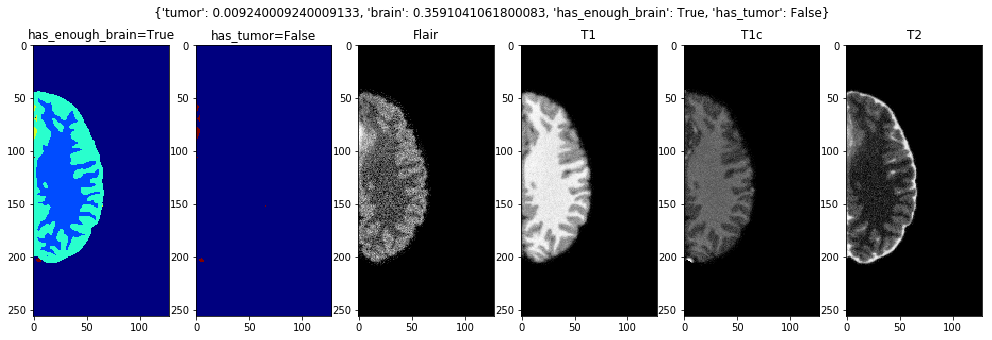

In [11]:
# Visualize a healthy sample
sample = 'HG0008'
slide = 106

label = labels[sample][slide]
fla = flair[sample][slide]
it1 = t1[sample][slide]
it1c = t1c[sample][slide]
it2 = t2[sample][slide]

met = get_labels(label)

plt.rcParams['figure.figsize'] = (17, 9)
fig, axarr = plt.subplots(1, 6)
axarr[0].imshow(label)
axarr[0].set_title('has_enough_brain=' + str(met['has_enough_brain']))
axarr[1].imshow(label > 2)
axarr[1].set_title('has_tumor=' + str(met['has_tumor']))
axarr[2].imshow(1.0 - fla, cmap='Greys')
axarr[2].set_title('Flair')
axarr[3].imshow(1.0 - it1, cmap='Greys')
axarr[3].set_title('T1')
axarr[4].imshow(1.0 - it1c, cmap='Greys')
axarr[4].set_title('T1c')
axarr[5].imshow(1.0 - it2, cmap='Greys')
axarr[5].set_title('T2')

fig.suptitle(met, y=0.77)
plt.show()

In [12]:
# Now create a dataframe and compute the label values
dataset = []
for sample in labels.keys():
    for slide in range(labels[sample].shape[0]):
        rightside = labels[sample][slide]
        met = get_labels(rightside)
        met['sample_name'] = sample
        met['slide'] = slide
        met['flair'] = flair[sample][slide]
        met['t1'] = t1[sample][slide]
        dataset.append(met)
stats = pd.DataFrame(dataset)


In [13]:
stats[stats.has_enough_brain].head()


,brain,flair,has_enough_brain,has_tumor,sample_name,slide,t1,tumor
47,0.306904,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,True,HG0018,47,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.269396
48,0.314611,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,True,HG0018,48,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.253889
49,0.321503,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,True,HG0018,49,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.246362
50,0.328630,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,True,HG0018,50,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.239605
51,0.338179,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,True,HG0018,51,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.234513


In [14]:
# Select and study 20 random samples
tostudy = np.random.choice(stats['sample_name'].unique(), 20, replace=False)


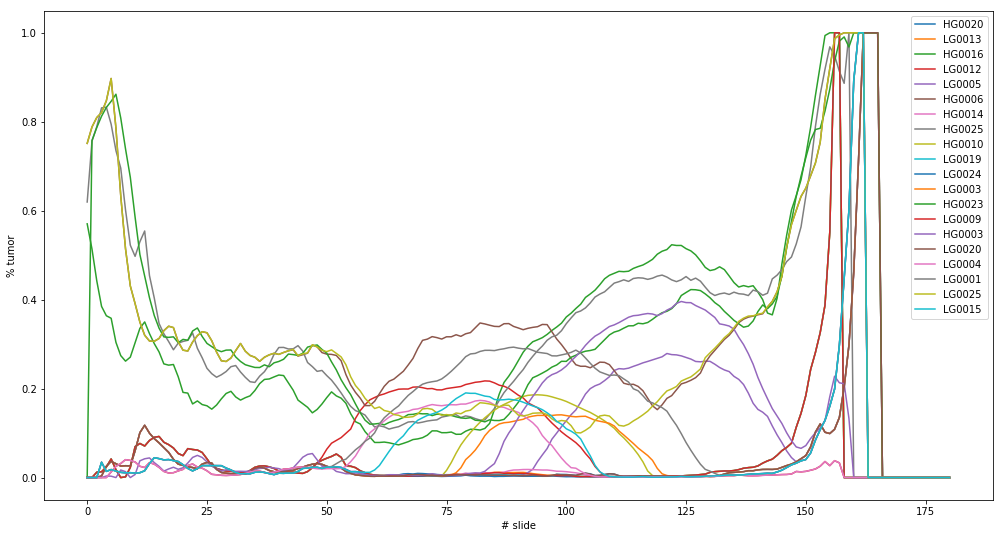

In [15]:
for sample in tostudy:
    plt.plot(
        stats[stats['sample_name'] == sample].slide,
        stats[stats['sample_name'] == sample].tumor,
        label=sample)
plt.xlabel('# slide')
plt.ylabel('% tumor')
plt.legend()
plt.show()


In [16]:
# Build dataset
# We  construct  two  training  scenarios:
# - Unpaired: For the CycleGAN we use an unpaired training scenario which keeps the distribution fixed 
# in the source domain D_a (with 50% healthy and 50% tumor samples)and changes the ratio of
# healthy to cancer samples in the target domain D_b to simulate  how  the  distribution
# matching  works  when  the  target  distribution  is irrelevant to the source distribution.
# - Paired: For the CondGAN and L1 models we use a paired training scenario where both the source and
# target domains have the same proportion of healthy to tumor examples because they have to be
# presented as pairs to the model.

In [17]:
print 'Total image slices: ', stats.shape[0]


Total image slices:  9050


In [18]:
# Select slices with enough brain
base = stats[stats.has_enough_brain]
print 'Total image slices with enough brain:' , base.shape[0]


Total image slices with enough brain: 3540


In [19]:
print '# raw with tumor: ', Counter(base.has_tumor)[True]


# raw with tumor:  2472


In [20]:
# Split on patients so the classifier is not trained on people
# in the holdout set.
num_patients = base.sample_name.unique().shape[0]
print '# patients: ', num_patients
# Take the first 30 patients for training
train_pat = base.sample_name.unique()[:30]
# Take the remaining 20 patients for the holdout set
holdout_pat = base.sample_name.unique()[30:]


# patients:  50


In [21]:
train = base[base.sample_name.isin(train_pat)]
print 'Training patient id: ', train.sample_name.unique()


Training patient id:  ['HG0018' 'HG0019' 'HG0012' 'HG0013' 'HG0010' 'HG0011' 'HG0016' 'HG0017'
 'HG0014' 'HG0015' 'HG0023' 'HG0022' 'HG0021' 'LG0005' 'LG0004' 'LG0007'
 'LG0006' 'LG0001' 'LG0003' 'LG0002' 'LG0025' 'LG0024' 'LG0009' 'LG0022'
 'LG0021' 'LG0020' 'HG0009' 'HG0008' 'HG0002' 'HG0025']


In [22]:
holdout = base[base.sample_name.isin(holdout_pat)]
print 'Holdout patient id: ', holdout.sample_name.unique()


Holdout patient id:  ['HG0001' 'HG0003' 'HG0024' 'HG0005' 'HG0004' 'HG0007' 'HG0006' 'HG0020'
 'LG0023' 'LG0008' 'LG0016' 'LG0017' 'LG0014' 'LG0015' 'LG0012' 'LG0013'
 'LG0010' 'LG0011' 'LG0018' 'LG0019']


In [23]:
print '# training examples: ', train.shape[0]
print '# train raw with tumor: ', Counter(train.has_tumor)[True]

print '# holdout examples: ', holdout.shape[0]
print '# holtout raw with tumor: ', Counter(holdout.has_tumor)[True]


# training examples:  2125
# train raw with tumor:  1421
# holdout examples:  1415
# holtout raw with tumor:  1051


In [24]:
def sample_ratio(samples, ratio_with_tumor, dataframe):

    num_withtumor = int(np.round(samples * ratio_with_tumor))
    num_notumor = int(np.round(samples * (1.0 - ratio_with_tumor)))

    with_tumor = np.random.choice(
        dataframe[dataframe.has_tumor == True].index, num_withtumor, replace=False)
    print '# with tumor unique', len(np.unique(with_tumor))
    without_tumor = np.random.choice(
        dataframe[dataframe.has_tumor != True].index, num_notumor, replace=False)
    print '# without tumor unique', len(np.unique(without_tumor))

    return dataframe.loc[np.concatenate([with_tumor, without_tumor], axis=0)]


In [25]:
# Build domaina train set, 700 examples, 50% tumor
domaina = sample_ratio(700, 0.5, train)
print 'domaina, # examples: ', domaina.shape[0]
print 'domaina, 700 examples, 50% has tumor: ', Counter(domaina.has_tumor)[True] / 700.

for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    print str(i*100) + ' % has tumor'
    # Build domainb train set, 700 examples, vary the percentage of tumors from 0 to 100%
    domainb = sample_ratio(700, i, train)
    print'domainb, # examples: ', domainb.shape[0]
    print 'domainb, 700 examples, ' + str(i*100) + ' % has tumor: ', Counter(domainb.has_tumor)[True] / 700.
    thispath = path + 'brats2013_' + str(i)
    thispath_paired = path_paired + 'brats2013_' + str(i)
    if not os.path.exists(thispath):
        os.makedirs(thispath + '/trainA')
        os.makedirs(thispath + '/testA')
        os.makedirs(thispath + '/trainB')
        os.makedirs(thispath + '/testB')
    print 'path unpaired: ', thispath
    
    if not os.path.exists(thispath_paired):
        os.makedirs(thispath_paired + '/trainA')
        os.makedirs(thispath_paired + '/testA')
        os.makedirs(thispath_paired + '/trainB')
        os.makedirs(thispath_paired + '/testB')
    print 'path paired: ', thispath_paired

    # For unpaired
    for i, row in domaina.iterrows():
        # Select Flair examples
        name = str(row['sample_name']) + '-' + str(row.slide) + '-' + \
            str(row.has_tumor)
        imsave(thispath + '/trainA/' + name + '.png', row.flair)
        imsave(thispath + '/testA/' + name + '.png', row.flair)
    for i, row in domainb.iterrows():
        name = str(row["sample_name"]) + "-" + str(row.slide) + "-" + \
            str(row.has_tumor)
        # Select T1 examples
        imsave(thispath + "/trainB/" + name + ".png", row.t1)
        imsave(thispath + "/testB/" + name + ".png", row.t1)

    # For paired
    for i, row in domainb.iterrows():
        name = str(row["sample_name"]) + "-" + str(row.slide) + "-" + \
            str(row.has_tumor)
        # Select T1 examples        
        imsave(thispath_paired + "/trainB/" + name + ".png", row.t1)
        imsave(thispath_paired + "/testB/" + name + ".png", row.t1)
        # Select Flair examples (domaina)
        imsave(thispath_paired + "/trainA/" + name + ".png", row.flair)
        imsave(thispath_paired + "/testA/" + name + ".png", row.flair)


# with tumor unique 350
# without tumor unique 350
domaina, # examples:  700
domaina, 700 examples, 50% has tumor:  0.5
0.0 % has tumor
# with tumor unique 0
# without tumor unique 700
domainb, # examples:  700
domainb, 700 examples, 0.0 % has tumor:  0.0
path unpaired:  cyclegan/datasets/brats2013-var/brats2013_0.0
path paired:  cyclegan/datasets/brats2013-paired/brats2013_0.0
10.0 % has tumor
# with tumor unique 70
# without tumor unique 630
domainb, # examples:  700
domainb, 700 examples, 10.0 % has tumor:  0.1
path unpaired:  cyclegan/datasets/brats2013-var/brats2013_0.1
path paired:  cyclegan/datasets/brats2013-paired/brats2013_0.1
20.0 % has tumor
# with tumor unique 140
# without tumor unique 560
domainb, # examples:  700
domainb, 700 examples, 20.0 % has tumor:  0.2
path unpaired:  cyclegan/datasets/brats2013-var/brats2013_0.2
path paired:  cyclegan/datasets/brats2013-paired/brats2013_0.2
30.0 % has tumor
# with tumor unique 210
# without tumor unique 490
domainb, # examples:  

In [26]:
# Build holdhout test set, 350 examples, 50% tumor
holdout_bal = sample_ratio(350, 0.5, holdout)


# with tumor unique 175
# without tumor unique 175


In [27]:
if not os.path.exists(holdoutpath):
    os.makedirs(holdoutpath + '/trainA')
    os.makedirs(holdoutpath + '/testA')
    os.makedirs(holdoutpath + '/trainB')
    os.makedirs(holdoutpath + '/testB')

print 'path holdout: ', thispath

for i, row in holdout_bal.iterrows():
    name = str(row['sample_name']) + '-' + str(row.slide) + '-' + str(row.has_tumor)
    # Select Flair examples
    imsave(holdoutpath + '/trainA/' + name + '.png', row.flair)
    imsave(holdoutpath + '/testA/' + name + '.png', row.flair)
    # Select T1 examples
    imsave(holdoutpath + '/trainB/' + name + '.png', row.t1)
    imsave(holdoutpath + '/testB/' + name + '.png', row.t1)


path holdout:  cyclegan/datasets/brats2013-var/brats2013_1.0


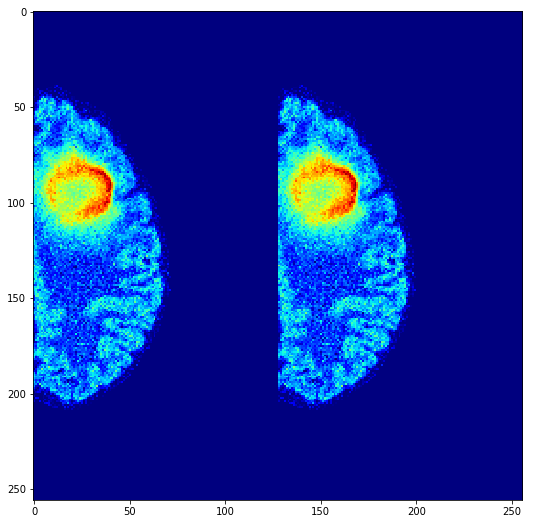

In [28]:
# Check that the images have been correctly recorded
# Visualize a sample

# Take a sample
img = holdout_bal[(holdout_bal.sample_name == "HG0001") &
                    (holdout_bal.slide == 105)].flair.values[0]

# Load the image from the path
img_ = imread(
    'cyclegan/datasets/brats2013-holdout/trainA/HG0001-105-True.png')
# Re-Scale between 0 and 1
img_ = img_.astype(np.float)

plt.imshow(np.concatenate([img, img_], axis=1))
plt.show()
